In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from scipy.stats import pearsonr, spearmanr

---

# Load data

We will look at 4 different state fairs that span a variety of climates and that were the largest of the US: Minnesota, Texas, New York and North Carolina.

In [50]:
attendance2 = pd.read_csv("state_fair_attendance_v4.csv", parse_dates = ["date"], dayfirst=True)
#attendance2['date'] = pd.to_datetime(attendance2['date'])

MN_prec = pd.read_csv("MN_Prism.csv", parse_dates = True)
NY_prec = pd.read_csv("NY_Prism.csv", parse_dates = True)
TX_prec = pd.read_csv("TX_Prism.csv", parse_dates = True)
NC_prec = pd.read_csv("NC_Prism.csv", parse_dates = True)

In [51]:
attendance2[attendance2['state']=='MN'].head()

,state,year,date,attendance
0,MN,2018,2018-08-23,122695
1,MN,2018,2018-08-24,108059
2,MN,2018,2018-08-25,222194
3,MN,2018,2018-08-26,184715
4,MN,2018,2018-08-27,124438


In [52]:
MN_prec['state']='MN'
MN_prec['date'] = pd.to_datetime(MN_prec['date'])
NY_prec['state']='NY'
NY_prec['date'] = pd.to_datetime(NY_prec['date'])
TX_prec['state']='TX'
TX_prec['date'] = pd.to_datetime(TX_prec['date'])
NC_prec['state']='NC'
NC_prec['date'] = pd.to_datetime(NC_prec['date'])


In [53]:
# PRISM rainfall data runs from 12pm to 12pm the following day, we found that subtracting a day for this reason was best
# especially considering that attendance is expected to peak in the afternoon/evening rather than morning
MN_prec['date'] = MN_prec.date - pd.Timedelta(days=1)
NY_prec['date'] = NY_prec.date - pd.Timedelta(days=1)
TX_prec['date'] = TX_prec.date - pd.Timedelta(days=1)
NC_prec['date'] = NC_prec.date - pd.Timedelta(days=1)

In [54]:
df = attendance2.merge(MN_prec, on=['state','date'], how='left').merge(NC_prec, on=['state','date'], how='left',suffixes=(None, '_NC')).merge(TX_prec, on=['state','date'], how='left',suffixes=(None, '_TX')).merge(NY_prec, on=['state','date'], how='left',suffixes=(None, '_NY'))
df = df.fillna(0)
df['prec'] = df['precip']+ df['precip_NC']+df['precip_NY']+df['precip_TX']
df = df.drop(['precip','precip_NC','precip_NY', 'precip_TX'], axis=1)
df.head()

,state,year,date,attendance,prec
0,MN,2018,2018-08-23,122695,2.79
1,MN,2018,2018-08-24,108059,32.78
2,MN,2018,2018-08-25,222194,0.00
3,MN,2018,2018-08-26,184715,0.72
4,MN,2018,2018-08-27,124438,5.10


In [55]:
# ensures we can use pandas timeseries functions
df['date']=pd.to_datetime(df['date'])

---
# T-test between 2 groups: rainy and non rainy days

We compare the means of attendance rates for days with and without rain.

In [56]:
import scipy
scipy.__version__

'1.7.2'

In [57]:
rain = df[df['prec']>0]['attendance']
no_rain = df[df['prec']==0]['attendance']

In [58]:
from scipy import stats

In [59]:
ttest = stats.ttest_ind(rain, no_rain, equal_var=False, alternative="less", permutations=10000,
                random_state=2)

print("P value:",ttest[1])

P value: 0.0453


P value is below the conventional threshold of 0.05

---
# Scale
We first use sklearn's Quantile Transformer, which is a robust preprocessing scheme that "renders variables measured at different scales more directly comparable" (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)

In [60]:
from sklearn.preprocessing import QuantileTransformer

In [61]:
transformer_prec = [('prec_transform', QuantileTransformer(), ['prec'])]
col_transform = ColumnTransformer(transformers=transformer_prec, remainder = "drop" )

scaled_prec = col_transform.fit_transform(df)
df["scaled_prec"] = scaled_prec


C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning:

n_quantiles (1000) is greater than the total number of samples (360). n_quantiles is set to n_samples.



In [62]:

# scaling attendance sepaately
scaled_df = pd.DataFrame()
scaled_attendances = np.array([])
for state in df['state'].unique():
    state_df = df[df['state']==state]
    transformer_attendance = [('attendance_transform', QuantileTransformer(), ['attendance'])]
    col_transform = ColumnTransformer(transformers=transformer_attendance, remainder = "drop" )

    scaled_attendance = col_transform.fit_transform(state_df)
    state_df['scaled_attendance'] = scaled_attendance
    scaled_df = pd.concat([scaled_df,state_df], ignore_index=True)

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning:

n_quantiles (1000) is greater than the total number of samples (36). n_quantiles is set to n_samples.

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning:

n_quantiles (1000) is greater than the total number of samples (87). n_quantiles is set to n_samples.

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [63]:
scaled_df[(scaled_df['state']=='NC')&(scaled_df['prec']>-1)]

,state,year,date,attendance,prec,scaled_prec,scaled_attendance
36,NC,2015,2015-10-15,50327,0.0,0.0,0.058140
37,NC,2015,2015-10-16,90954,0.0,0.0,0.534884
38,NC,2015,2015-10-17,126666,0.0,0.0,0.924419
39,NC,2015,2015-10-18,97906,0.0,0.0,0.616279
40,NC,2015,2015-10-19,63989,0.0,0.0,0.174419
...,...,...,...,...,...,...,...
118,NC,2013,2013-10-23,68252,0.0,0.0,0.220930
119,NC,2013,2013-10-24,102176,0.0,0.0,0.686047
120,NC,2013,2013-10-25,82163,0.0,0.0,0.476744
121,NC,2013,2013-10-26,122223,0.0,0.0,0.883721


In [64]:
# calculate Pearson's correlation before 2019
for state in scaled_df.state.unique():
    corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2019)]['prec'], scaled_df[(scaled_df['state']==state) & (scaled_df['year']<2019)]['attendance'])
    print('Pearsons correlation {}: {}'.format(state,corr))

Pearsons correlation MN: -0.5192703618096502
Pearsons correlation NC: -0.15902435776281199
Pearsons correlation NY: -0.27159742259764513
Pearsons correlation TX: -0.2575030224499544


In [65]:
fig = px.scatter(scaled_df, x="prec", y="attendance",hover_data=['year'], color='state')
fig.show()

In [66]:
# 2019 was removed for NC because it appeared as an outlier (in red above).
scaled_df = scaled_df.drop(scaled_df[(scaled_df['state']=='NC') & (scaled_df['year']==2019)].index)

In [67]:
fig = px.scatter(scaled_df, x="prec", y="attendance",hover_data=['year'], color='state')
fig.show()

In [68]:
# calculate Pearson's correlation (all years)
for state in scaled_df.state.unique():
    corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['prec']>0)]['prec'], scaled_df[(scaled_df['state']==state) & (scaled_df['prec']>0)]['attendance'])
    print('Pearsons correlation {}: {}'.format(state,corr))

Pearsons correlation MN: -0.5143400934180269
Pearsons correlation NC: -0.48551101323735
Pearsons correlation NY: -0.13659232980277639
Pearsons correlation TX: -0.3667971819390203


In [69]:
# calculate Pearson's correlation (pre-covid up to 2019)
for state in scaled_df.state.unique():
    corr, _ = pearsonr(scaled_df[(scaled_df['state']==state) & (scaled_df['prec']>0)&(scaled_df['year']<2020)]['prec'], scaled_df[(scaled_df['state']==state) & (scaled_df['prec']>0)&(scaled_df['year']<2020)]['attendance'])
    print('Pearsons correlation {}: {}'.format(state,corr))

Pearsons correlation MN: -0.6556076481480855
Pearsons correlation NC: -0.8156647325777969
Pearsons correlation NY: -0.26613381455497537
Pearsons correlation TX: -0.34736621716633986


As expected, we see a negative correlation between rainfall and attendance. The strength of the correlation is weaker when we add data from 2020 onwards, and we hypothesize that it is due to the COVID-19 pandemic. Therefore, we will now only take into account data up to and including 2019. However, it is important to note that there are many variables other than rainfall that have an effect on attendance. 

---
# Optimized curve fit

In [70]:
from sklearn.preprocessing import MaxAbsScaler, RobustScaler 

from scipy.optimize import curve_fit

## Reprocessing dataframe

Here, we reprocess the data from each frame individually. For each state, the distribution of attendance rates is likely to be different due to individual fair size, population, etc... Therefore, we scale each of these fairs individually.

The MaxAbsScaler used "does not destroy any sparsity", which is important as the days with precipatation are very sparse in the dataset. Furthermore, "maximal absolute value of each feature in the training set will be 1.0" which allows us to compare between states. (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)


In [71]:
MN_df = df[df['state']=='MN']
TX_df = df[df['state']=='TX']
NC_df = df[df['state']=='NC']
NC_df = NC_df.drop(NC_df[(NC_df['state']=='NC') & (NC_df['year']==2019)].index) #removing the outlier
NY_df = df[df['state']=='NY']


In [72]:
def preprocess_state_df(df):
    df = df[df['year']<2020]
    scaler_prec = MaxAbsScaler()
    X_train_prec = scaler_prec.fit_transform(np.array(df ['prec']).reshape(-1,1))
    scaler_att = MaxAbsScaler()
    X_train_att = scaler_att.fit_transform(np.array(df['attendance']).reshape(-1,1))
    df['scaled_prec'] = X_train_prec
    df['scaled_att'] = X_train_att
    df = df[df['prec']>0]

    q_low = df["attendance"].quantile(0.0)
    q_hi  = df["attendance"].quantile(1)
    df_filtered = df[(df["attendance"] < q_hi) & (df["attendance"] > q_low)]
    return df_filtered, scaler_prec, scaler_att

In [73]:
MN_df_scaled, MN_scaler_prec, MN_scaler_att = preprocess_state_df(MN_df)

NC_df_scaled, NC_scaler_prec, NC_scaler_att = preprocess_state_df(NC_df)

NY_df_scaled, NY_scaler_prec, NY_scaler_att = preprocess_state_df(NY_df)


C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [74]:
TX_df_scaled, TX_scaler_prec, TX_scaler_att = preprocess_state_df(TX_df)
px.scatter(TX_df_scaled, x='scaled_prec',y='scaled_att')
px.scatter(TX_df_scaled, x='prec',y='attendance')

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
# we assume the function follows
def func(t, a, b, c):
    return a*np.exp(-b*t-c) 



In [76]:
def fit_curve(state_df):
    x = np.array(state_df["scaled_prec"])
    y = np.array(state_df["scaled_att"])
    popt, pcov = curve_fit(func, x, y,maxfev=5000, bounds=(0, np.inf))
    p,a = zip(*sorted(zip(x, func(x, *popt))))
    plt.plot(p,a, label="fit: a={}, b={}, c={}".format(popt[0],popt[1],popt[2]))
    plt.scatter(x,y)

    plt.xlabel('Scaled precipitation')
    plt.ylabel('Scaled attendance')
    plt.show()
    return popt

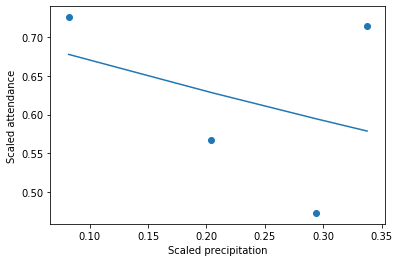

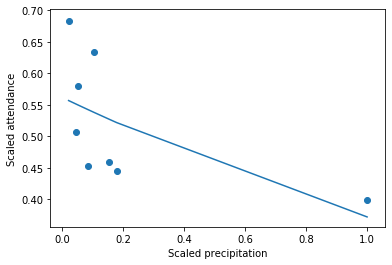

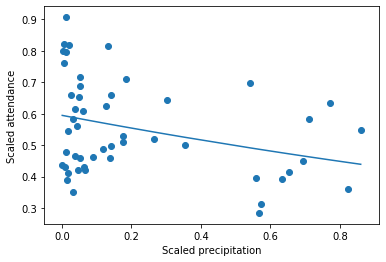

In [77]:
popt_NC = fit_curve(NC_df_scaled)
popt_MN = fit_curve(MN_df_scaled)
popt_NY = fit_curve(NY_df_scaled)


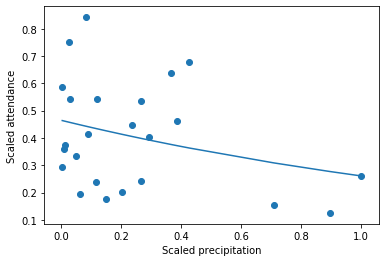

array([1.32205753, 0.57600882, 1.04593536])

In [78]:
popt_TX = fit_curve(TX_df_scaled)
popt_TX

---
# Vendors - revenue loss

In [79]:
def adjust_vendor_revenue(df,precipitation, gross_revenue, popt, scaler_prec):
    
    scaled_prec = scaler_prec.transform(np.array(precipitation).reshape(-1, 1))
    no_rain_att =  func(0, popt[0],popt[1],popt[2]) #returns scaled attendance no rain
    y_pred = func(scaled_prec[0,0], popt[0],popt[1],popt[2]) #returns scaled attendance with rain
    sf = (y_pred)/no_rain_att

    new_revenue = sf*gross_revenue

    return (new_revenue)

In [80]:
# example: the new daily revenue of a vendor in Texas that usually earns 10000 daily, if there is 3 mm of rain
adjust_vendor_revenue(TX_df_scaled, 3,10000, popt_TX, TX_scaler_prec)

9744.856895578776

In [81]:
def plot_adj_rev(scaled_df, popt, scaler_prec):
    adj_rev = []
    for i in range(100):
        adj_rev.append(adjust_vendor_revenue(scaled_df, i,10000, popt, scaler_prec))
    return adj_rev


In [82]:
tx_adj = plot_adj_rev(TX_df_scaled, popt_TX,TX_scaler_prec)

In [83]:
ny_adj = plot_adj_rev(NY_df_scaled, popt_NY, NY_scaler_prec)

In [84]:
nc_adj = plot_adj_rev(NC_df_scaled, popt_NC,NC_scaler_prec)

In [85]:
mn_adj = plot_adj_rev(MN_df_scaled, popt_MN, MN_scaler_prec)

In [86]:
x = np.arange(100)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=nc_adj,
                    mode='lines',
                    name='North Carolina'))
fig.add_trace(go.Scatter(x=x, y=ny_adj,
                    mode='lines',
                    name='New York'))
fig.add_trace(go.Scatter(x=x, y=mn_adj,
                    mode='lines',
                    name='Minnesota'))
fig.add_trace(go.Scatter(x=x, y=tx_adj,
                    mode='lines',
                    name='Texas'))                
# Edit the layout
fig.update_layout(title='US State Fair Vendor Revenue Adjusted for Rainfall',
                   xaxis_title='Daily Precipitation (mm)',
                   yaxis_title='Daily Revenue (USD)')
fig.show()

## Vendor simulation (with costs)

Now we add on expenses and costs of running a stall

In [87]:
def rainfall_profit(df_scaled, popt, rainfall, scaler_prec, daily_revenue, percent_commission=0.20, percent_sales_tax=0.0738,percent_admission=0.02, percent_labour=0.18, percent_food=0.25, percent_income_tax = 0.12, extra_costs=0):
    adjusted_rev = adjust_vendor_revenue(df_scaled, rainfall,daily_revenue, popt, scaler_prec)
    commission = percent_commission*adjusted_rev
    sales_tax = percent_sales_tax*adjusted_rev

    admission = percent_admission*daily_revenue
    labour = percent_labour*daily_revenue
    food_cost = percent_food*daily_revenue

    pre_tax_profit = adjusted_rev - commission - sales_tax - admission - labour - food_cost - extra_costs


    calc_income_tax = lambda a : a*percent_income_tax if a > 0 else 0
    income_tax = calc_income_tax(pre_tax_profit)

    net_profit = pre_tax_profit - income_tax
    return net_profit


In [88]:
# save dfs
MN_df_scaled.to_csv("MN_df_scaled.csv", index=False)
TX_df_scaled.to_csv("TX_df_scaled.csv", index=False)
NC_df_scaled.to_csv("NC_df_scaled.csv", index=False)
NY_df_scaled.to_csv("NY_df_scaled.csv", index=False)


In [89]:
rainfall_profit(MN_df_scaled, popt_MN,0,MN_scaler_prec,70000, extra_costs=0)

17013.92

In [113]:
# function to plot profit, assuming no extra costs, per day
def plot_profit(df_scaled, popt, scaler_prec,revenue, percent_commission=0.20, percent_sales_tax=0.0738,percent_admission=0.02, percent_labour=0.18, percent_food=0.25, percent_income_tax = 0.12,extra_costs=0):
    profit_list = []
    for i in range(1,120):
        profit_list.append(rainfall_profit(df_scaled, popt,i,scaler_prec, revenue,percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=extra_costs))

    return profit_list

In [114]:
ny_profit = plot_profit(NY_df_scaled, popt_NY, NY_scaler_prec, 10000, extra_costs=0)
tx_profit = plot_profit(TX_df_scaled, popt_TX, TX_scaler_prec, 10000, extra_costs=0)
nc_profit = plot_profit(NC_df_scaled, popt_NC, NC_scaler_prec, 10000, extra_costs=0)
mn_profit = plot_profit(MN_df_scaled, popt_MN, MN_scaler_prec, 10000, extra_costs=0)

In [115]:
x = np.arange(120)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=nc_profit,
                    mode='lines',
                    name='North Carolina'))
fig.add_trace(go.Scatter(x=x, y=ny_profit,
                    mode='lines',
                    name='New York'))
fig.add_trace(go.Scatter(x=x, y=mn_profit,
                    mode='lines',
                    name='Minnesota'))
fig.add_trace(go.Scatter(x=x, y=tx_profit,
                    mode='lines',
                    name='Texas'))                
# Edit the layout
fig.update_layout(title='US State Fair Daily Profit Adjusted for Rainfall - with Expenses',
                   xaxis_title='Daily Precipitation (mm)',
                   yaxis_title='Daily Profit (USD)')
fig.show()

In [109]:
def total_profit_fair(df_scaled, popt, scaler_prec, total_revenue, prec_list, percent_commission=0.20, percent_sales_tax=0.0738,percent_admission=0.02, percent_labour=0.18, percent_food=0.25, percent_income_tax = 0.12, extra_costs=0):
    profit_list = []
    daily_revenue = total_revenue/len(prec_list)
    for prec in prec_list:
        profit_list.append(rainfall_profit(df_scaled, popt,prec, scaler_prec, daily_revenue, percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=extra_costs))
    
    total_profit = sum(profit_list)
    rainy_days = len([x for x in prec_list if x > 0])

    print('Total days: {}'.format(len(prec_list)))
    print('Rainy days: {}'.format(rainy_days))
    print('Daily Profit: {}'.format(profit_list))
    print('Total Profit: {}'.format(total_profit))

    return prec_list, profit_list, rainy_days, total_profit

    

In [110]:
# example: a new york state fair vendor that has 0 extra costs, daily rainfall is 100,60,60,0,0,5,2,0,0,8,10,30,0,0 (mm)
ex = total_profit_fair(NY_df_scaled, popt_NY, NY_scaler_prec, 70000, [100,60,60,0,0,5,2,0,0,8,10,30,0,0],extra_costs=0)

Total days: 14
Rainy days: 8
Daily Profit: [-1461.6779926420986, -797.7790755065027, -797.7790755065027, 1215.28, 1215.28, 980.3481646454662, 1119.149089012971, 1215.28, 1215.28, 847.7636874548898, 762.6896096491643, 40.74792553195763, 1215.28, 1215.28]
Total Profit: 7985.142332639345


In [95]:
scalers_dict = {'NY':NY_scaler_prec,
'NC':NC_scaler_prec,
'TX':TX_scaler_prec,
'MN':MN_scaler_prec}

The function below gives an average for all 4 state fairs rather than having to select a specific location

In [111]:
def total_profit_fair_us(total_revenue, scalers_dict, prec_list, percent_commission=0.20, percent_sales_tax=0.0738,percent_admission=0.02, percent_labour=0.18, percent_food=0.25, percent_income_tax = 0.12,extra_costs=0):
    profit_list_MN = []
    profit_list_TX = []
    profit_list_NC = []
    profit_list_NY = []
    daily_revenue = total_revenue/len(prec_list)
    for prec in prec_list:
        profit_list_MN.append(rainfall_profit(MN_df_scaled, popt_MN,prec, scalers_dict['MN'], daily_revenue, percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=0))
        profit_list_TX.append(rainfall_profit(TX_df_scaled, popt_TX,prec, scalers_dict['TX'],daily_revenue, percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=0))
        profit_list_NC.append(rainfall_profit(NC_df_scaled, popt_NC,prec, scalers_dict['NC'], daily_revenue, percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=0))
        profit_list_NY.append(rainfall_profit(NY_df_scaled, popt_NY,prec,scalers_dict['NY'], daily_revenue, percent_commission=percent_commission, percent_sales_tax=percent_sales_tax,percent_admission=percent_admission, percent_labour=percent_labour, percent_food=percent_food, percent_income_tax = percent_income_tax, extra_costs=0))
    
    avg_profit_list = np.average(np.array([profit_list_MN, profit_list_TX, profit_list_NC, profit_list_NY]), axis=0)
    
    total_profit_MN = sum(profit_list_MN)
    total_profit_TX = sum(profit_list_TX)
    total_profit_NC = sum(profit_list_NC)
    total_profit_NY = sum(profit_list_NY)

    avg_total_profit = (total_profit_MN + total_profit_TX + total_profit_NC + total_profit_NY)/4

    rainy_days = len([x for x in prec_list if x > 0])

    print('Total days: {}'.format(len(prec_list)))
    print('Rainy days: {}'.format(rainy_days))
    print('Average Daily Profit: {}'.format(avg_profit_list))
    print('Average Total Profit: {}'.format(avg_total_profit))

    return prec_list, avg_profit_list, rainy_days, avg_total_profit

In [112]:
ex2 = total_profit_fair_us(70000, scalers_dict,[0,0,0,0,0,5,2,100,100,100,10,30,30,0],extra_costs=0)

Total days: 14
Rainy days: 8
Average Daily Profit: [ 1215.28        1215.28        1215.28        1215.28
  1215.28         759.83032111  1013.61262379 -1410.69900443
 -1410.69900443 -1410.69900443   411.15304151  -331.47944053
  -331.47944053  1215.28      ]
Average Total Profit: 4581.220092044772


In [98]:
# save scalers
import joblib as jb

for state, scaler in scalers_dict.items():
    scaler_filename = "{}_scaler_prec.save".format(state)
    jb.dump(scaler, scaler_filename) 


# Add insurance

In [99]:
def add_insurance(prec_list, profit_list, threshold, payout, premium):
    paid = False
    new_profit_list = profit_list.copy()
    for i in range(len(prec_list)):
        if (prec_list[i]>threshold) and (paid==False):
            new_profit_list[i] = profit_list[i] + payout
            paid = True
        elif (paid==True):
            new_profit_list[i] = profit_list[i]
        elif (paid==False):
            new_profit_list[i] = profit_list[i] - premium

    return new_profit_list


# Find average fair duration

In [100]:
date_df = scaled_df.groupby(['state','year'],as_index=False)['date'].agg(np.ptp) 
date_df.head()

,state,year,date
0,MN,2018,11 days
1,MN,2019,11 days
2,MN,2021,11 days
3,NC,2013,10 days
4,NC,2014,10 days


In [101]:
date_df['date'].mean()

Timedelta('12 days 23:02:24')

# Plot output bar charts

In [102]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [103]:
def plotly_prec_profit(prec_list, profit_list):

    fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True)
    

    fig.add_trace(
        go.Bar(x=[x for x in range(1,len(prec_list)+1)], y=prec_list,name="Precipitation"),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(x=[x for x in range(1,len(profit_list)+1)], y=profit_list, name = "Profit"),
        row=2, col=1
    )


    fig.update_layout(title_text="Daily Precipitation and Profit",)

    # Update xaxis properties
    fig.update_xaxes(title_text="Day",row=1, col=1)
    fig.update_xaxes(title_text="Day", row=2, col=1)


    # Update yaxis properties
    fig.update_yaxes(title_text="Precipitation (mm)", row=1, col=1)
    fig.update_yaxes(title_text="Expected Profit (USD)", row=2, col=1)

    fig.show()
    

In [104]:
prec_list, avg_profit_list, rainy_days, total_profit = total_profit_fair_us(70000,scalers_dict, [0,0,0,0,0,5,2,0,0,50,100,90,90,0],extra_costs=0)

plotly_prec_profit(prec_list,avg_profit_list)

Total days: 14
Rainy days: 6
Average Daily Profit: [ 1215.28        1215.28        1215.28        1215.28
  1215.28         759.83032111  1013.61262379  1215.28
  1215.28        -749.48943111 -1410.69900443 -1308.9961201
 -1308.9961201   1215.28      ]
Average Total Profit: 6717.502269160825


If we add insurance

In [105]:
new_profit_lst = add_insurance(prec_list,avg_profit_list,40,20000,1000)
plotly_prec_profit(prec_list,new_profit_lst)